In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [5]:
def generate_random_weighted_graph(n,low,high):
    g = nx.generators.complete_graph(n)
    g.add_weighted_edges_from([(a,b,np.random.randint(low,high)) for a,b in g.edges()])
    nx.set_node_attributes(g,nx.spring_layout(g),"pos")
    return g
def plot_graph(g,title=" ",highlight_edges=[]):
    pos = nx.get_node_attributes(g,"pos")
    plt.figure(figsize=(17,17))
    plt.title(title)
    nx.draw(g,pos=pos,labels={x:x for x in g.nodes},width=2)
    weights = nx.get_edge_attributes(g,"weight")
    nx.draw_networkx_edge_labels(g,pos,edge_labels=weights,label_pos=4);
    nx.draw_networkx_edges(g,pos,edgelist=highlight_edges,edge_color="r",width=3)
    nx.draw_networkx_edge_labels(g,pos,edge_labels={
        e:w 
        for e,w in weights.items()
        if e in map(lambda x:tuple(sorted(x)),highlight_edges)
        },
        font_color="r",
        label_pos=.4   
    )
    plt.show()


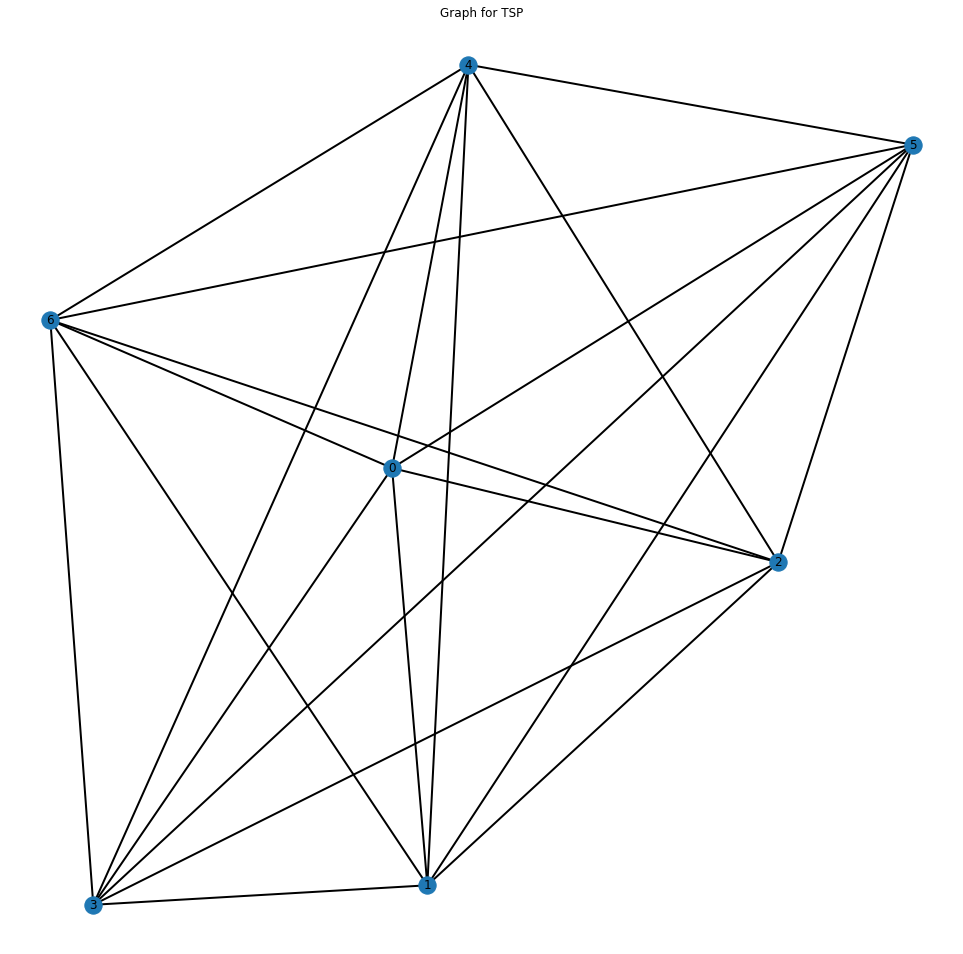

In [6]:
np.random.seed(3)
g = generate_random_weighted_graph(7,1,20)
plot_graph(g,"Graph for TSP")

In [9]:
def nearest_neighbour_initialization(g,method = "greedy", closed_tour=False):
    curr_node = np.random.choice(g.nodes) 
    path = [curr_node]
    not_visited = set(g.nodes)-{curr_node}
    while not_visited:
        not_visited_neighbours = not_visited&set(g.neighbors(curr_node))
        key =lambda x: g[curr_node][x]["weight"]
        if method=="greedy":
            curr_node = min(not_visited_neighbours,key = key) 
        elif method == "stochastic":
            curr_node = select_stochastic(not_visited_neighbours,key = key, inverse= True)
        path.append(curr_node)
        not_visited.remove(curr_node)
    
    if closed_tour:
        path.append(path[0])
    return path

In [10]:
np.random.seed(1)
print(nearest_neighbour_initialization(g))
print(nearest_neighbour_initialization(g,closed_tour=True))

[5, 1, 4, 0, 2, 6, 3]
[3, 5, 1, 4, 0, 2, 6, 3]


In [11]:
from collections import defaultdict

In [12]:
def has_cycle(g):
    try:
        nx.find_cycle(g)
    except nx.NetworkXNoCycle:
        return False
    return True

def get_path_from_edges(edges,closed_tour=False):
    path_graph = nx.Graph(edges)
    curr = min(path_graph.nodes,key=path_graph.degree) 
    path,visited = [curr],{curr}
    while len(path)<len(path_graph):
        curr = (set(path_graph.neighbors(curr))-visited).pop()
        visited.add(curr)
        path.append(curr)
    if closed_tour:
        path.append(path[0])
    return path

In [13]:
def shortest_edge_initialization(g,method="greedy", closed_tour = False):
    edge_list = set(g.edges)
    times_visited  = defaultdict(int)
    tour = set() 
    max_tour_len = len(g) if closed_tour else len(g)-1
    key = nx.get_edge_attributes(g,"weight").get
    while len(tour)<max_tour_len:
        if method == "greedy":
            u,v = min(edge_list, key=key)
        elif method == "stochastic":
            u,v = select_stochastic(edge_list,key=key,inverse=True)
        
        times_visited[u]+=1
        times_visited[v]+=1
        tour.add((u,v))
        edge_list.remove((u,v))

        for u,v in set(edge_list):
            if (
                (has_cycle(nx.Graph(tour|{(u,v)})) and len(tour) != len(g)-1) 
                or times_visited[u] ==2 or times_visited[v] ==2

            ):
                edge_list.remove((u,v))

    return get_path_from_edges(tour,closed_tour=closed_tour)

In [15]:
np.random.seed(1)
print(shortest_edge_initialization(g))
print(shortest_edge_initialization(g,closed_tour=True))

[3, 4, 0, 2, 6, 5, 1]
[0, 2, 6, 5, 1, 3, 4, 0]


In [17]:
inv_path_length = lambda x: 1/nx.path_weight(g,x,"weight")
path_length_func = lambda x: nx.path_weight(g,x,"weight")

def roulette_wheel_selection(fitness_func,parents):
    fitness = np.array(list(map(fitness_func,parents)))
    path_length = np.array(list(map(path_length_func,parents)))
    fitness = fitness/fitness.sum()
    n = len(parents)
    return [parents[i] for i in np.random.choice(n,n,p=fitness)]

In [18]:
def make_valid_tour(p,nodes):
    unvisited = set(nodes)-set(p)
    indices = defaultdict(list)
    for i in range(len(p)):
        indices[p[i]].append(i)
    visited_twice = {node for node in indices if len(indices[node])==2}
    for node in visited_twice:
        change_index = np.random.choice(indices[node])
        p[change_index] = unvisited.pop()
    return p

def partially_matched_crossover(p1,p2):
    pt = np.random.randint(1,len(p1)-1) 
    c1 = p1[:pt] + p2[pt:]
    c2 = p2[:pt] + p1[pt:]
    nodes = set(p1)
    return make_valid_tour(c1,nodes),make_valid_tour(c2,nodes)

In [22]:
np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g,closed_tour=False) for _ in range(n_population)]
selected_population = roulette_wheel_selection(inv_path_length  ,population)
parents = selected_population[:2]
print(parents)
print(partially_matched_crossover(*parents))

[[3, 4, 0, 2, 6, 5, 1], [3, 4, 0, 2, 6, 5, 1]]
([3, 4, 0, 2, 6, 5, 1], [3, 4, 0, 2, 6, 5, 1])


In [23]:
def order_crossover(p1,p2):
    start = np.random.randint(0,len(p1)-1)
    end = np.random.randint(start+1,len(p1) if start !=0 else len(p1)-1)
    def fill_blanks(p1,p2,s,e):
        
        unvisited_nodes = p2.copy()
        for node in p1[s:e]:
            unvisited_nodes.remove(node)

        c = p1.copy()
        for i in range(len(p1)):
            if i<s or i>=e:
                c[i] = unvisited_nodes.pop(0)
        return c

    c1 = fill_blanks(p1,p2,start,end)
    c2 = fill_blanks(p2,p1,start,end)
    return c1,c2

In [24]:
np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g,closed_tour=False) for _ in range(n_population)]
selected_population =  roulette_wheel_selection(inv_path_length,population)
parents = selected_population[:2]
print(parents)
print(order_crossover(*parents))

[[3, 4, 0, 2, 6, 5, 1], [3, 4, 0, 2, 6, 5, 1]]
([3, 4, 0, 2, 6, 5, 1], [3, 4, 0, 2, 6, 5, 1])


In [25]:
def inversion_mutation(p):
    start = np.random.randint(0,len(p)-1)
    end = np.random.randint(start+1,len(p)+1)
    subtour = p[start:end]
    c = p.copy()
    for i in range(start,end):
        c[i] = subtour.pop()
    return c

In [26]:
np.random.seed(3)
n_population = 8
population = [shortest_edge_initialization(g,closed_tour=False) for _ in range(n_population)]
subject = population[0]
print(subject,inversion_mutation(subject))

[3, 4, 0, 2, 6, 5, 1] [3, 4, 0, 2, 6, 5, 1]


In [27]:
def insertion_mutation(p):
    i = np.random.randint(1,len(p))
    k = np.random.randint(0,len(p)-1)
    c = p.copy()
    c.insert(k,c.pop(i))
    return c

In [28]:
np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g,closed_tour=False) for _ in range(n_population)]
subject = population[0]
print(subject,insertion_mutation(subject))

[3, 4, 0, 2, 6, 5, 1] [3, 0, 2, 6, 5, 4, 1]
